# Project Analysis NoteBook
## Data Input

The datasets used in this project are available from ['The Cancer Genome Atlas' (TCGA)](www.http://cancergenome.nih.gov/) consortium.  Clinical and RNA-seq gene count data sets can be downloaded via a provided data portal, or using an R package called [TCGA2STAT](https://cran.r-project.org/web/packages/TCGA2STAT/index.html).  The R script used to download the data sets for this project are available in the local repository for this project ([GitHub link](https://github.com/CCThompson82/Prostate_metastasis/tree/master/Dataset_setup)).  If run locally, two [feather](https://github.com/wesm/feather) files will be written to the working directory, which will be read and imported with the python scripts below.

In [1]:
%run -i Dataset_cleanup/arrange_DF.py

Clinical data set imported!
Features: 21 
Patients: 499

 The following features do not provide any information: 
 ['Composite.Element.REF' 'ethnicity' 'gender' 'pathologicstage'
 'pathologyMstage' 'tumortissuesite'] 

Variables that are not known at initial diagnosis: 
 ['daystodeath' 'daystolastfollowup' 'daystopsa' 'histologicaltype'
 'numberoflymphnodes' 'pathologyTstage' 'radiationtherapy' 'residualtumor'
 'vitalstatus'] 

Variables that are known at the time of diagnosis:
 ['clinical_index' 'dateofinitialpathologicdiagnosis' 'gleasonscore'
 'pathologyNstage' 'psavalue' 'race' 'yearstobirth']


Gene Counts data set imported!
Features: 20501 
Patients: 497


Transforming gene counts to transcript per million (TPM)

Transformation Successful!

497 Gene count estimate profiles have been transformed from gene counts to transcripts per million reads (TPM)


## Data Exploration
### Clinical Information - including metastasis label
There is missing clinical data in many of the features, including what will become the outcome label ('pathologyNstage' - metastasis state).  The series **'y_all'** is the full list of pathologyNstage, where 'n1' represents metastasis, and 'n0' represents no metastasis observed to date.  Some observations have no metastasis state recorded and are represented by NaN in y_all.  These are removed for the trimmed **'y'** series.  

In [2]:
print("Total observations in original dataset:",clinical.shape[0])

not_labeled = y_all[y_all.isnull()] 
y = y_all[y_all.notnull()]

print("\nObservations with metastasis label:",y.shape[0])
print("Unlabeled observations (removed:)",not_labeled.shape[0])


Total observations in original dataset: 499

Observations with metastasis label: 426
Unlabeled observations (removed:) 73


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

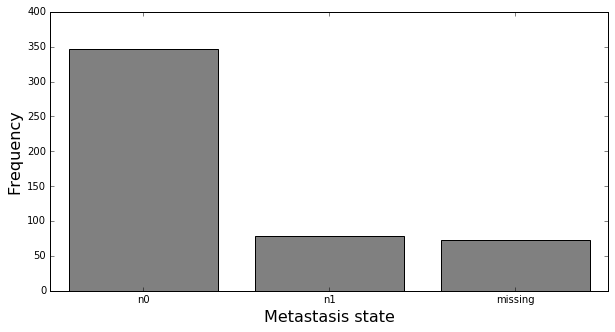

In [4]:
D = (('n0', y[y =='n0'].shape[0]), 
     ('n1', y[y =='n1'].shape[0]), 
     ('missing' , len(not_labeled)))
exp_fig = plt.figure(figsize=(10,5))
A = exp_fig.add_subplot(1,1,1)
ind = A.bar(range(0,3), height= [D[0][1], D[1][1], D[2][1]], align='center', color = 'grey')
A.set_xticks(range(0,3))
A.set_ylabel('Frequency', fontsize=16)
A.set_xlabel('Metastasis state', fontsize=16)
A.set_ylim(0,400)
A.set_xticklabels([D[0][0], D[1][0], D[2][0]])  #Must be a better way to do this...
ep = plt.show

#### Gene Activation (Gene counts) Dataset
The starting dataset, **'X_all'**, includes the transformed transcript per million (TPM) estimates for all RNA-seq profiles.  However some of the observations in this set do not have corresponding y_labels, as the clinical data set contains missing information.

Therefore X_all was trimmed to include only those observations where a finite y label exists, to yield **'X'**.  

In [5]:
"""Limit X to only observations where a target label is present."""
X = X_all.loc[set(y.index).intersection(X_all.index)]  #Only observations that also have a known metastasis state are kept.
y = y.loc[set(X.index).intersection(y.index)]
print("X dimensions:",X.shape,"\ny dimensions:",y.shape)

X dimensions: (424, 20501) 
y dimensions: (424,)


In [6]:
X_no_y = X_all.loc[list(not_labeled.index)]
print("Dimensions of unlabeled dataset:",X_no_y.shape)

Dimensions of unlabeled dataset: (73, 20501)


In [7]:
X.isnull().values.any()

False

### Exploratory Visualization

#### Gleason Score versus Metastasis analysis
The Gleason score is the gold-standard diagnostic test for cancer severity, but is not highly correlative with metastatic disease.  

In [8]:
clinical['gleasonscore'] = pd.to_numeric(clinical['gleasonscore'], errors= 'coerce')
clinical['gleasonscore'].isnull().any()

False

<function matplotlib.pyplot.show>

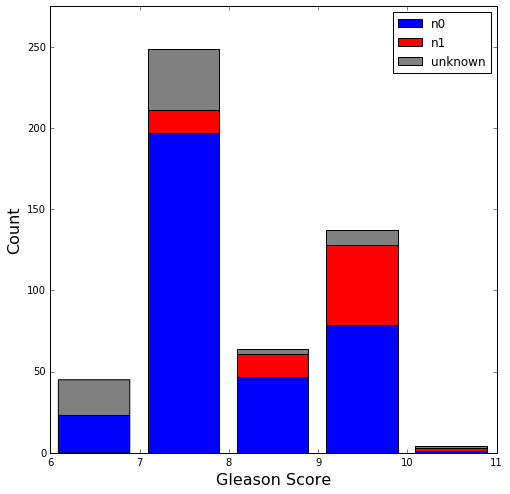

In [9]:
GS_hist = plt.figure(figsize=(8,8))
A = GS_hist.add_subplot(1,1,1)
sub = (('n1', ))

subs = [clinical.loc[y_all[y_all == 'n0'].index]['gleasonscore'],
        clinical.loc[y_all[y_all == 'n1'].index]['gleasonscore'],
        clinical.loc[y_all[y_all.isnull()].index]['gleasonscore']]

bins = [5.99, 6.99, 7.99, 8.99, 9.99, 10.99]
A.hist(subs, bins, label =['n0', 'n1', 'unknown'], color = ['blue','red','grey'], stacked = True)
A.set_ylim(0,275)
A.set_ylabel('Count', fontsize=16)
A.set_xlabel('Gleason Score', fontsize =16)
A.legend()
plt.show

## Managing missing labels

In [10]:
print(clinical.shape)
print(y_all.shape)

(499, 5)
(499,)


In [11]:
targets = list(set(clinical.loc[clinical['gleasonscore']== 6, :].index).intersection(y_all.loc[y_all.isnull()].index))

In [12]:
print(sum(y_all == 'n0'))
y_all.loc[targets] = 'n0'
print(sum(y_all == 'n0'))

347
369


/Users/ccthomps/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
print("Total observations in original dataset:",clinical.shape[0])

not_labeled = y_all[y_all.isnull()] 
y = y_all[y_all.notnull()]

print("\nObservations with metastasis label:",y.shape[0])
print("Unlabeled observations (removed:)",not_labeled.shape[0])

Total observations in original dataset: 499

Observations with metastasis label: 448
Unlabeled observations (removed:) 51


In [14]:
"""Limit X to only observations where a target label is present."""
X = X_all.loc[set(y.index).intersection(X_all.index)]  #Only observations that also have a known metastasis state are kept.
y = y.loc[set(X.index).intersection(y.index)]
print("X dimensions:",X.shape,"\ny dimensions:",y.shape)

X dimensions: (446, 20501) 
y dimensions: (446,)


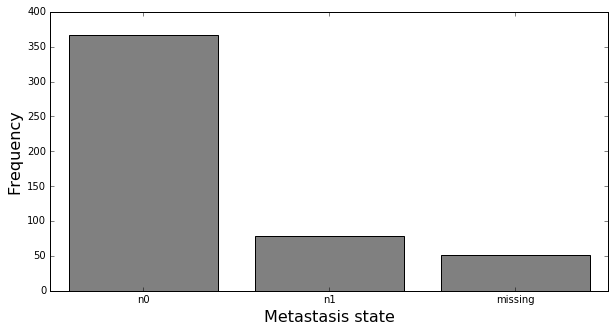

In [15]:
D = (('n0', y[y =='n0'].shape[0]), 
     ('n1', y[y =='n1'].shape[0]), 
     ('missing' , len(not_labeled)))
exp_fig = plt.figure(figsize=(10,5))
A = exp_fig.add_subplot(1,1,1)
ind = A.bar(range(0,3), height= [D[0][1], D[1][1], D[2][1]], align='center', color = 'grey')
A.set_xticks(range(0,3))
A.set_ylabel('Frequency', fontsize=16)
A.set_xlabel('Metastasis state', fontsize=16)
A.set_ylim(0,400)
A.set_xticklabels([D[0][0], D[1][0], D[2][0]])  #Must be a better way to do this...
ep = plt.show

<function matplotlib.pyplot.show>

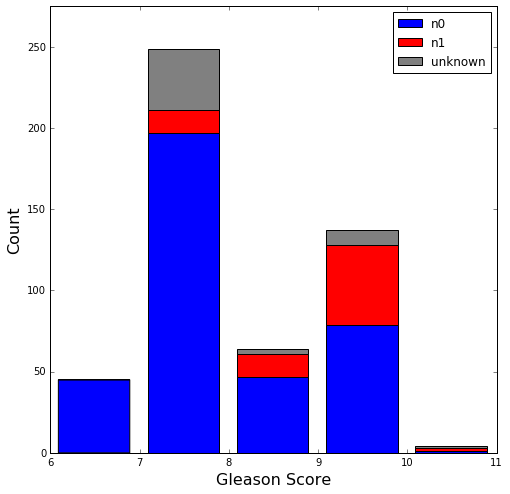

In [16]:
GS_hist = plt.figure(figsize=(8,8))
A = GS_hist.add_subplot(1,1,1)
sub = (('n1', ))

subs = [clinical.loc[y_all[y_all == 'n0'].index]['gleasonscore'],
        clinical.loc[y_all[y_all == 'n1'].index]['gleasonscore'],
        clinical.loc[y_all[y_all.isnull()].index]['gleasonscore']]

bins = [5.99, 6.99, 7.99, 8.99, 9.99, 10.99]
A.hist(subs, bins, label =['n0', 'n1', 'unknown'], color = ['blue','red','grey'], stacked = True)
A.set_ylim(0,275)
A.set_ylabel('Count', fontsize=16)
A.set_xlabel('Gleason Score', fontsize =16)
A.legend()
plt.show

### Test Train Split

In [17]:
from sklearn.model_selection import train_test_split


In [18]:
train_k = round(len(y)*0.75)
test_k = len(y) - train_k

In [19]:
seed = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= test_k, 
                                                    train_size = train_k,
                                                    random_state = seed,
                                                    stratify = y)

### Benchmark 
#### Determine the Null Error / Accuracy Rates for Prediction
As the dataset is unbalanced, knowledge of the null rate - i.e. the performance measure given if a model were to predict the positive label indiscriminantly - is an important benchmark upon which to improve.  

In [20]:
from sklearn.metrics import matthews_corrcoef, fbeta_score, classification_report
from sklearn.model_selection import cross_val_score

In [21]:
"""Scorers needed throughout code:"""
from sklearn.metrics import make_scorer
MCC_scorer = make_scorer(matthews_corrcoef, greater_is_better=True, needs_proba=False, needs_threshold=False)
fbeta_scorer = make_scorer(fbeta_score, greater_is_better=True, needs_proba=False, needs_threshold=False, pos_label='n1', beta = 2)

In [22]:
y_n1 = ['n1']*len(y)
print('Model predicts indiscriminantly, "n1"')
print('\nNull F beta: ', fbeta_score(y, y_n1, pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(y, y_n1),"\n")
print(classification_report(y, y_n1, labels = ['n0','n1']))


Model predicts indiscriminantly, "n1"

Null F beta:  0.518372703412

MCC:  0.0 

             precision    recall  f1-score   support

         n0       0.00      0.00      0.00       367
         n1       0.18      1.00      0.30        79

avg / total       0.03      0.18      0.05       446



/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

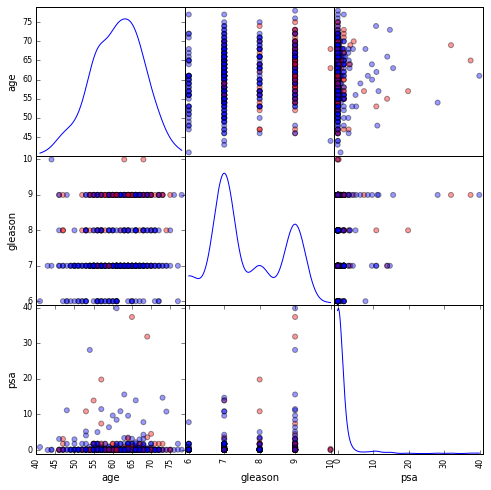

In [24]:
gleason = clinical['gleasonscore']
age = pd.to_numeric(clinical['yearstobirth'], errors = 'coerce')
age.fillna(value = np.mean(age), inplace=True)
psa = pd.to_numeric(clinical['psavalue'], errors= 'coerce')
psa.fillna(value = np.mean(psa), inplace =True)
gleason = gleason.loc[y.index]

benchmarkDF = pd.DataFrame({'gleason': gleason,
                            'age':age ,
                            'psa' : psa,
                            'y' : y}, index=X.index)

sm = pd.scatter_matrix(benchmarkDF, 
                       alpha=0.4, 
                       figsize= (8,8), 
                       diagonal = 'kde', 
                       c = benchmarkDF['y'].replace({'n1': 'red','n0':'blue'}), 
                       s = 100)

In [25]:
benchmarkDF.drop(['y'], axis=1, inplace = True)


In [26]:
benchmarkDF = benchmarkDF.reindex(y.index)

<function matplotlib.pyplot.show>

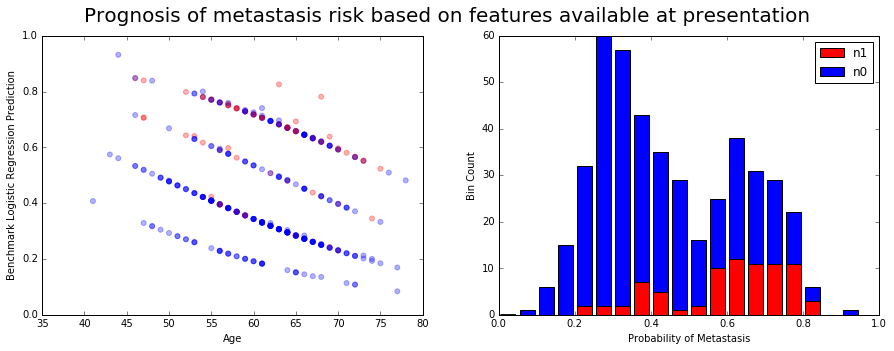

In [27]:
estimator = LogisticRegression(penalty='l2',
                              dual=False,
                              tol=0.0001,
                              C=1,
                              fit_intercept=True,
                              intercept_scaling=1,
                              class_weight='balanced',
                              random_state=123,
                              solver='liblinear',
                              max_iter=100,
                              multi_class='ovr',
                              verbose=0,
                              warm_start=False,
                              n_jobs=1)

clf = GridSearchCV(estimator,
                   param_grid = {'C': [1,0.1, 0.01]},
                   scoring=fbeta_scorer,
                   fit_params=None,
                   n_jobs=1,
                   iid=True,
                   refit=True,
                   cv= 5,
                   verbose=0,
                   pre_dispatch='2*n_jobs',
                   error_score='raise')

clf.fit(benchmarkDF.loc[X_train.index, :], y_train)

clf_LR = clf.best_estimator_

bench_fig = plt.figure(figsize=(15,5))
A= bench_fig.add_subplot(1,2,1)
B = bench_fig.add_subplot(1,2,2)
A.scatter(benchmarkDF['age'], clf_LR.predict_proba(benchmarkDF)[:,1], 
          color = y.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.3,
          s = 25)
A.set_ylabel('Benchmark Logistic Regression Prediction')
A.set_xlabel('Age')
plt.suptitle('Prognosis of metastasis risk based on features available at presentation', fontsize=20)

groups = [clf_LR.predict_proba(benchmarkDF.loc[y[y=='n1'].index, :])[:,1], 
          clf_LR.predict_proba(benchmarkDF.loc[y[y=='n0'].index, :])[:,1]]
bins = np.arange(0,1,0.05)
B.hist(groups, label =['n1', 'n0'],  bins = bins, color = ['red','blue'], stacked = True)
B.set_xlabel('Probability of Metastasis')
B.set_ylabel('Bin Count')
A.set_ylim(0,1)
B.legend()
#bench_fig.title("Prediction of Metastasis")
plt.show

In [28]:
"Benchmark Performance on Test dataset"
print(clf_LR)
print('\nNull F beta: ', fbeta_score(y_test, clf_LR.predict(benchmarkDF.loc[y_test.index, :]), pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(y_test, clf_LR.predict(benchmarkDF.loc[y_test.index, :])),"\n")
print(classification_report(y_test, clf_LR.predict(benchmarkDF.loc[y_test.index, :]), labels = ['n0','n1']))


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Null F beta:  0.75

MCC:  0.528236515611 

             precision    recall  f1-score   support

         n0       0.97      0.76      0.85        92
         n1       0.45      0.90      0.60        20

avg / total       0.88      0.79      0.81       112



## Feature Reduction
### Univariate Feature that separate data labels

SelectKBest is a filtering function that utilizes a scoring function to filter a data set to the features that exhibit statistical difference when broken into class (metastasis state in this case).  This is a useful first step to remove all gene expression data where little difference in expression is observed between the two classes, as well as genes which are not expressed in either class, etc.  

In [29]:
from sklearn.feature_selection import SelectKBest, f_classif

In [30]:
K_selector = SelectKBest(f_classif, k = 'all') # using k=all here and will filter based on F-stat later.  
K = K_selector.fit(X, y)

/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 1595  1815  2267  4324  4341  4342  4343  4344  4345  4346  4347  4779
  4780  4781  4782  4787  4790  4791  4794  4795  4801  4803  5259  6032
  6776  6780  6783  7445  7551  7632  7633  7634  7635  7636  7732  9275
  9277  9287  9291  9419  9421  9423  9495 10092 11101 11929 12028 12488
 12527 12593 12606 13749 13963 14015 14129 14130 14131 14132 14726 14727
 14729 15109 15111 15112 16536 16538 16539 16541 16542 16543 16545 16546
 16547 16548 16549 16550 16576 16605 16608 16648 16668 16669 16670 16671
 16672 16673 16674 16675 16676 16677 16678 16679 16680 16681 16682 16683
 16684 16685 16686 16687 16688 16689 16690 16691 16692 16693 16694 16695
 16696 16697 16698 16699 16700 16701 16702 16703 16704 16705 16706 16707
 16708 16709 16710 16711 16712 16713 16714 16715 16716 16717 16718 16720
 16721 16722 16723 16724 16725 16726 16728 16729 16730 16731 16732 

In [31]:
K_df = pd.DataFrame({'Gene':X.columns, 'F_score':K.scores_})
K_df.dropna(inplace=True)

<function matplotlib.pyplot.show>

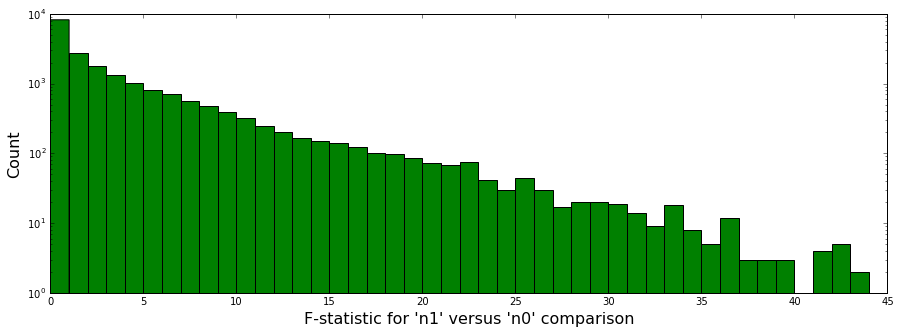

In [32]:
F_fig = plt.figure(figsize=(15,5))
A = F_fig.add_subplot(1,1,1)
A.hist(K_df['F_score'], bins=range(0,45,1), facecolor='green')
A.set_yscale('log')
A.set_ylabel('Count', fontsize=16)
A.set_xlabel("F-statistic for 'n1' versus 'n0' comparison", fontsize=16)
plt.show

## Scaling of Gene Count Data

In [33]:
from sklearn.preprocessing import scale

In [34]:
#scaler = MinMaxScaler(feature_range= (-1,1), copy =False)
X_all = pd.DataFrame(scale(X_all), columns = X_all.columns, index = [X_all.index])
X = X_all.loc[X.index]

In [35]:


X_k = X.loc[:,list(K_df[K_df['F_score'] > 5]['Gene'])]
print("New Dataset, X_k, has shape:",X_k.shape)

X_kk = X.loc[:,list(K_df[K_df['F_score'] > 25]['Gene'])]
print("New Dataset, X_kk, has shape:",X_kk.shape)


New Dataset, X_k, has shape: (446, 5094)
New Dataset, X_kk, has shape: (446, 247)


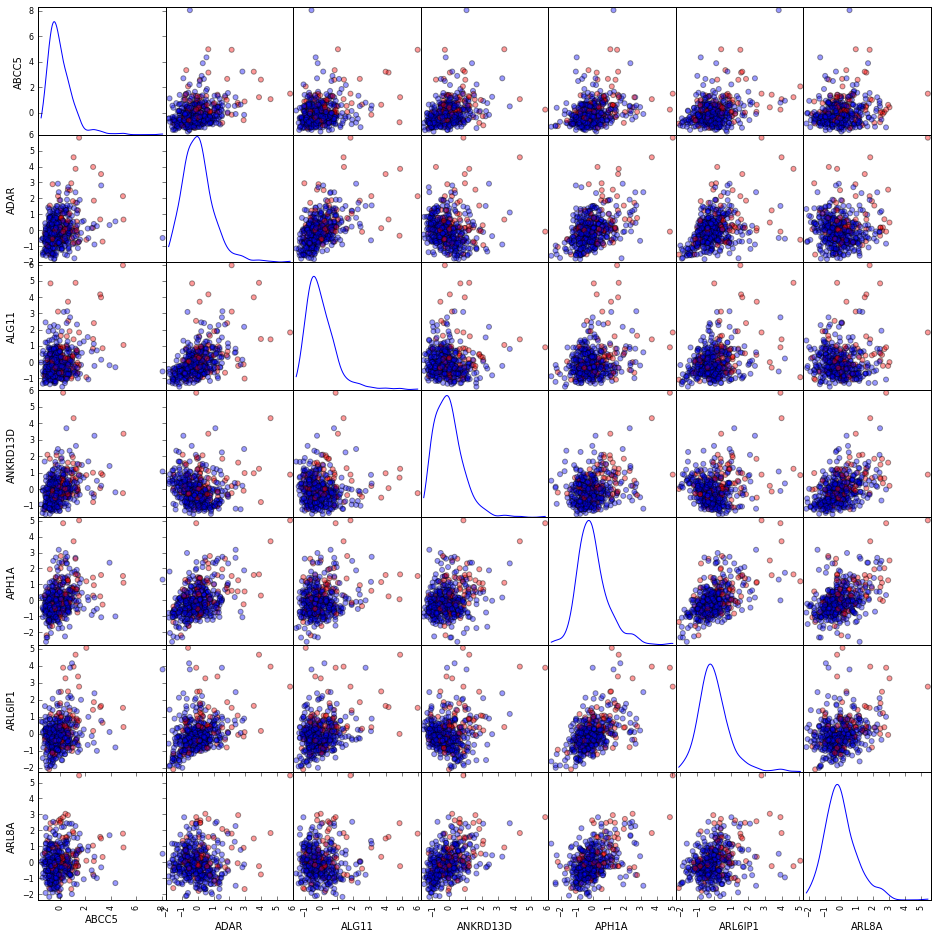

In [36]:
sm = pd.scatter_matrix(X_kk.iloc[:,0:7], 
                       alpha=0.4, 
                       figsize= (16,16), 
                       diagonal = 'kde', 
                       c = y.replace({'n1': 'red','n0':'blue'}), 
                       s = 100)

## Generate Models

The data is noisy...

An ensemble model is usually the most appropriate.  

## SVM with Recursive Feature Elimination

In [37]:
from sklearn.model_selection import learning_curve, validation_curve

/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages

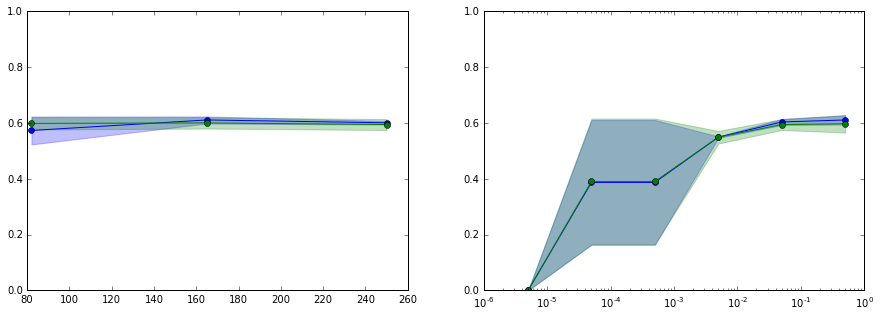

In [38]:
%run -i SVM/SVM.py #recursive feature elimination is slow O^n?

In [39]:
print(X_kk.columns[clf_svm_rf.support_])

Index(['GNE'], dtype='object')


In [40]:
clf_svm = SVC(C=0.05,
          kernel='linear',
          probability=False,
          tol=0.001,
          cache_size=200,
          gamma = 'auto',
          class_weight='balanced',
          verbose=False,
          max_iter=-1,
          random_state= 123)
clf_svm.fit(X_svm.loc[X_train.index,:], y_train)

SVC(C=0.05, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False)

## Improve SVM with gridsearch

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
param_grid = {'C': [5e-4, 5e-3, 1e-2, 5e-2],
              'class_weight': ['balanced',
                               {'n0':1, 'n1':1},
                               {'n0':1, 'n1':4}, 
                               {'n0':1, 'n1':8},
                               {'n0':1, 'n1':16}]}
clf_SVM = GridSearchCV(clf_svm, 
                       param_grid = param_grid, 
                       scoring=fbeta_scorer, 
                       fit_params=None, 
                       n_jobs=1, 
                       iid=False, 
                       refit=True, 
                       cv=4, 
                       verbose=0, 
                       pre_dispatch='2*n_jobs', 
                       error_score='raise')

In [43]:
clf_SVM.fit(X_svm.loc[X_train.index, :], y_train)

/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages

GridSearchCV(cv=4, error_score='raise',
       estimator=SVC(C=0.05, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'class_weight': ['balanced', {'n1': 1, 'n0': 1}, {'n1': 4, 'n0': 1}, {'n1': 8, 'n0': 1}, {'n1': 16, 'n0': 1}], 'C': [0.0005, 0.005, 0.01, 0.05]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(fbeta_score, beta=2, pos_label=n1), verbose=0)

In [44]:
#print(clf_SVM.grid_scores_)
print('\n\n',clf_SVM.best_params_, clf_SVM.best_score_)
print('\n\n',clf_SVM.best_estimator_)



 {'class_weight': 'balanced', 'C': 0.01} 0.6002096137897712


 SVC(C=0.01, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False)


In [45]:
clf_svm = clf_SVM.best_estimator_

## SVM Performance versus Training Set

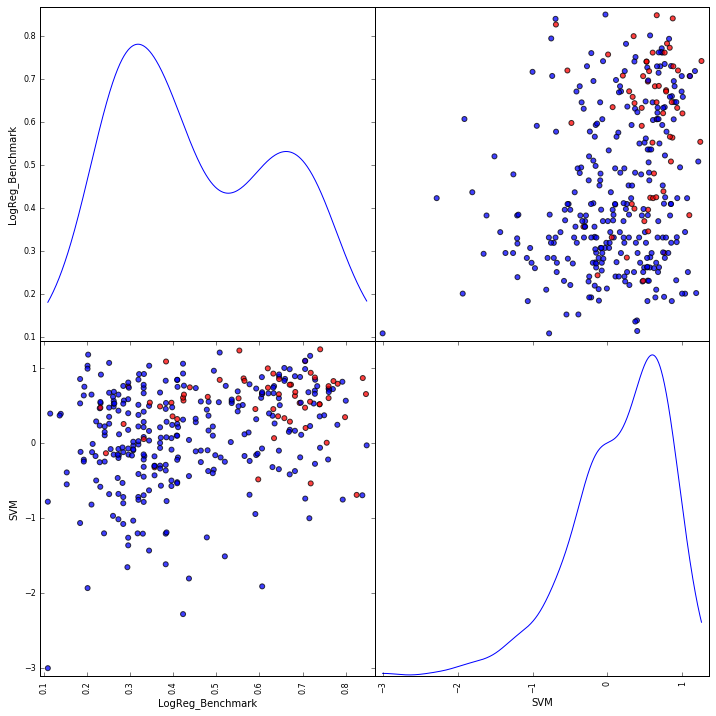

In [46]:
testDF = pd.DataFrame({'LogReg_Benchmark': clf_LR.predict_proba(benchmarkDF.loc[X_train.index])[:,1],  
                       'SVM': clf_svm.decision_function(X_svm.loc[X_train.index,:])}, index=y_train.index) 
sm = pd.scatter_matrix(testDF, 
                       alpha=0.75, 
                       figsize= (12,12), 
                       diagonal = 'kde', 
                       c = y_train.replace({'n1': 'red','n0':'blue'}), 
                       s = 100)

In [47]:
print(classification_report(y_train,
                            clf_svm.predict(X_svm.loc[X_train.index]),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_train, clf_svm.predict(X_svm.loc[X_train.index]), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(y_train, clf_svm.predict(X_svm.loc[X_train.index])))

             precision    recall  f1-score   support

         n0       0.96      0.43      0.59       275
         n1       0.26      0.92      0.40        59

avg / total       0.84      0.51      0.56       334

F beta:  0.604026845638

MCC:  0.272265451012


## Add Gleason Score to Data set, retrain SVM and test performance

In [48]:
print(gleason.shape)
print(X_svm.shape)
X_svm['gleason'] = gleason.reindex(X_svm.index)
print(X_svm.shape)

(446,)
(446, 1)
(446, 2)


In [49]:
clf_svm.fit(X_svm.loc[X_train.index], y_train)

SVC(C=0.01, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False)

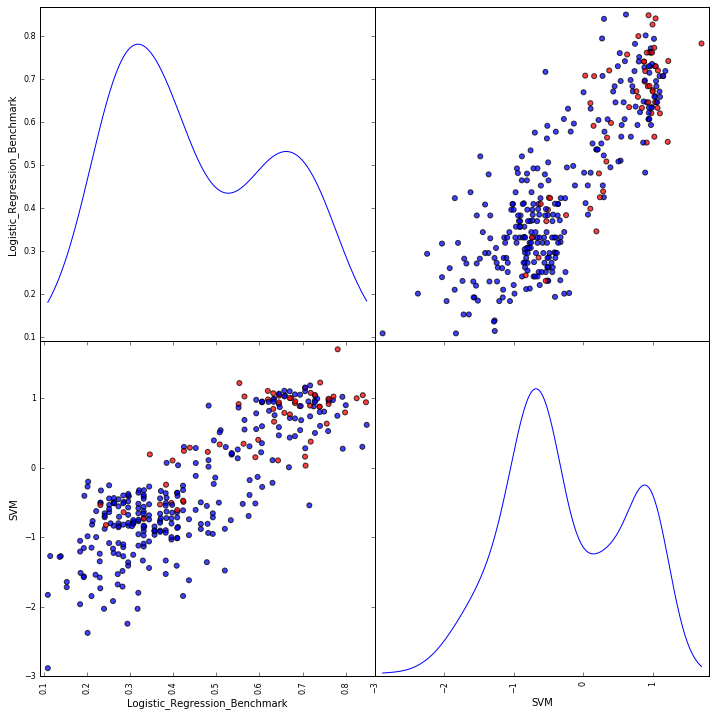

In [50]:
testDF = pd.DataFrame({'Logistic_Regression_Benchmark': clf_LR.predict_proba(benchmarkDF.loc[X_train.index])[:,1],  
                       'SVM': clf_svm.decision_function(X_svm.loc[X_train.index,:])}, index=y_train.index) 
sm = pd.scatter_matrix(testDF, 
                       alpha=0.75, 
                       figsize= (12,12), 
                       diagonal = 'kde', 
                       c = y_train.replace({'n1': 'red','n0':'blue'}), 
                       s = 100)

In [51]:
print(classification_report(y_train,
                            clf_svm.predict(X_svm.loc[X_train.index]),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_train, clf_svm.predict(X_svm.loc[X_train.index]), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(y_train, clf_svm.predict(X_svm.loc[X_train.index])))

             precision    recall  f1-score   support

         n0       0.94      0.70      0.80       275
         n1       0.36      0.80      0.50        59

avg / total       0.84      0.72      0.75       334

F beta:  0.643835616438

MCC:  0.39041213187


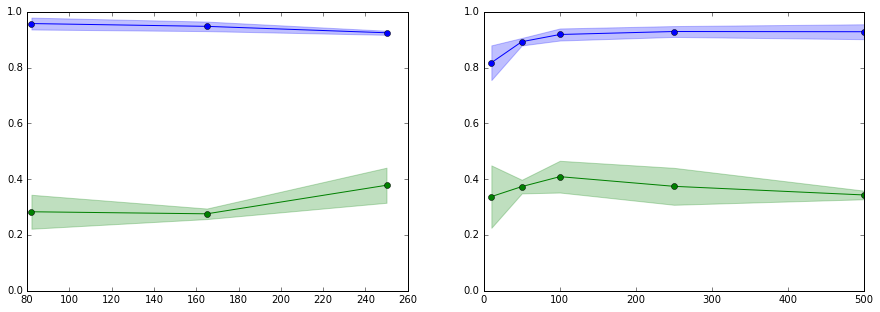

In [52]:
%run -i Random_Forest/RF.py

## Optimize Random Forest

In [53]:
clf_RF = RandomForestClassifier(n_estimators=100,
                                   criterion='gini',
                                   max_depth=3,
                                   min_samples_split=100,
                                   min_samples_leaf=25,
                                   min_weight_fraction_leaf=0.0,
                                   max_features= 0.05,
                                   max_leaf_nodes=None,
                                   bootstrap=True,
                                   oob_score=False,
                                   n_jobs=1,
                                   random_state=123,
                                   verbose=0,
                                   warm_start=False,
                                   class_weight='balanced')

In [54]:
param_grid = {'max_depth': [1,2,3],
              'class_weight': ['balanced',
                               {'n0':1, 'n1':4}, 
                               {'n0':1, 'n1':8},
                               {'n0':1, 'n1':16},
                               {'n0':1, 'n1':24}],
              'min_samples_leaf': [25, 50],
              'max_features': [0.025, 0.05, 0.075]}
clf_rf = GridSearchCV(clf_RF, 
                       param_grid = param_grid, 
                       scoring=fbeta_scorer, 
                       fit_params=None, 
                       n_jobs=1, 
                       iid=False, 
                       refit=True, 
                       cv=4, 
                       verbose=0, 
                       pre_dispatch='2*n_jobs', 
                       error_score='raise')

In [55]:
clf_rf.fit(X_k.loc[X_train.index,:], y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features=0.05,
            max_leaf_nodes=None, min_samples_leaf=25,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'class_weight': ['balanced', {'n1': 4, 'n0': 1}, {'n1': 8, 'n0': 1}, {'n1': 16, 'n0': 1}, {'n1': 24, 'n0': 1}], 'min_samples_leaf': [25, 50], 'max_features': [0.025, 0.05, 0.075], 'max_depth': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(fbeta_score, beta=2, pos_label=n1), verbose=0)

In [56]:
clf_rf.best_params_

{'class_weight': {'n0': 1, 'n1': 16},
 'max_depth': 3,
 'max_features': 0.05,
 'min_samples_leaf': 25}

In [57]:
clf_RF = clf_rf.best_estimator_


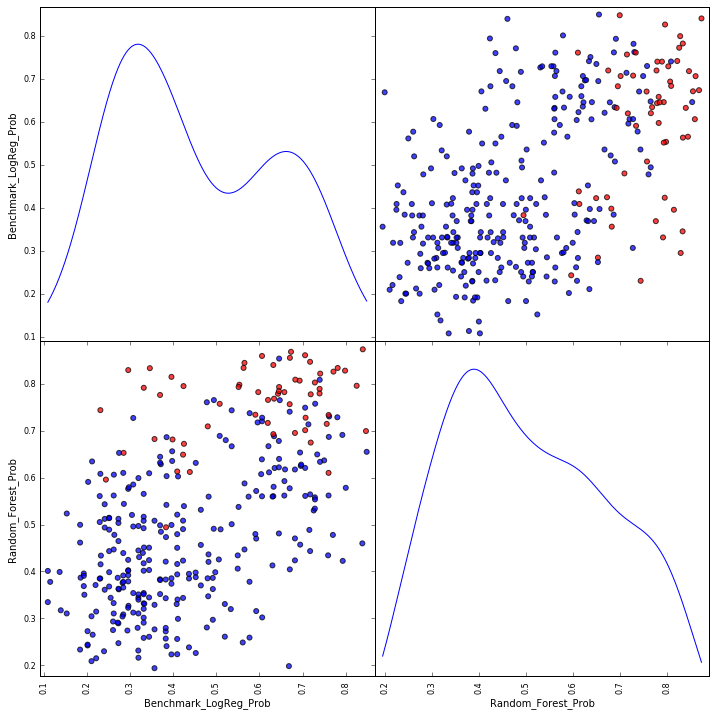

In [58]:
testDF = pd.DataFrame({'Benchmark_LogReg_Prob': clf_LR.predict_proba(benchmarkDF.loc[X_train.index])[:,1],  
                       'Random_Forest_Prob': clf_RF.predict_proba(X_k.loc[X_train.index,:])[:,1]}, 
                      index=y_train.index) 
sm = pd.scatter_matrix(testDF, 
                       alpha=0.75, 
                       figsize= (12,12), 
                       diagonal = 'kde', 
                       c = y_train.replace({'n1': 'red','n0':'blue'}), 
                       s = 100)

/Users/ccthomps/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


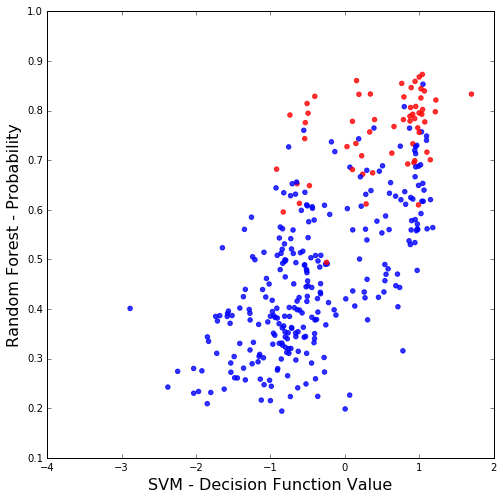

In [59]:
Train_Fig = plt.figure(figsize=(8,8))
A= Train_Fig.add_subplot(1,1,1)
A.scatter(clf_svm.decision_function(X_svm.loc[X_train.index,:]),
          clf_RF.predict_proba(X_k.loc[X_train.index,:])[:,1],
          color = y_train.replace({'n1':'red', 'n0':'blue'}),
          alpha = 0.8)
A.set_xlabel('SVM - Decision Function Value', fontsize = 16)
A.set_ylabel('Random Forest - Probability', fontsize =16)
A.legend()
plt.show()

In [60]:
print(classification_report(y_train,
                            clf_RF.predict(X_k.loc[X_train.index]),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_train, clf_RF.predict(X_k.loc[X_train.index]), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(y_train, clf_RF.predict(X_k.loc[X_train.index])))

             precision    recall  f1-score   support

         n0       0.99      0.63      0.77       275
         n1       0.36      0.98      0.53        59

avg / total       0.88      0.69      0.73       334

F beta:  0.730478589421

MCC:  0.464430566069


## Test for the best model

In [61]:
import math

/Users/ccthomps/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


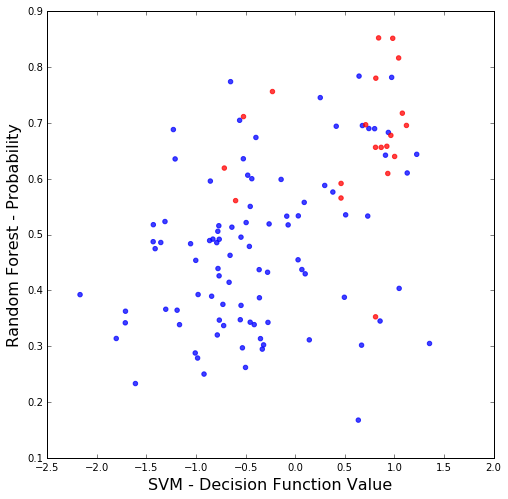

In [62]:
Test_Fig = plt.figure(figsize=(8,8))
A= Test_Fig.add_subplot(1,1,1)
A.scatter(clf_svm.decision_function(X_svm.loc[X_test.index,:]),
          clf_RF.predict_proba(X_k.loc[X_test.index,:])[:,1],
          color = y_test.replace({'n1':'red', 'n0':'blue'}),
          alpha = 0.75)
A.set_xlabel('SVM - Decision Function Value', fontsize = 16)
A.set_ylabel('Random Forest - Probability', fontsize =16)
A.legend()
plt.show()

In [63]:
print(classification_report(y_test,
                            clf_svm.predict(X_svm.loc[X_test.index]),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_test, clf_svm.predict(X_svm.loc[X_test.index]), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(y_test, clf_svm.predict(X_svm.loc[X_test.index])))

             precision    recall  f1-score   support

         n0       0.94      0.71      0.81        92
         n1       0.37      0.80      0.51        20

avg / total       0.84      0.72      0.75       112

F beta:  0.650406504065

MCC:  0.398885480029


In [64]:
print('\nF beta: ', fbeta_score(y_test, clf_RF.predict(X_k.loc[y_test.index, :]), pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(y_test, clf_RF.predict(X_k.loc[y_test.index, :])),"\n")
print(classification_report(y_test, clf_RF.predict(X_k.loc[y_test.index, :]), labels = ['n0','n1']))


F beta:  0.698529411765

MCC:  0.419627163708 

             precision    recall  f1-score   support

         n0       0.98      0.60      0.74        92
         n1       0.34      0.95      0.50        20

avg / total       0.87      0.66      0.70       112

